In [11]:
import numpy as np
import sys
import os
import math
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
np.set_printoptions(threshold=sys.maxsize) # show full ndarray
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Inference

## Static: reason for the bent down beam

In [27]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

**Likelihood**

In [105]:
nsample = 20
sample_start = 15
sample_end = 300
height = 30
F = 256

<AxesSubplot:xlabel='Distance', ylabel='Height'>

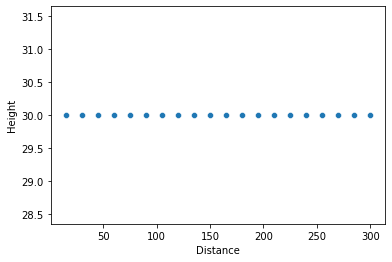

In [106]:
# Physical Beam
beam_samples = np.array(list(range(sample_start, sample_end+1, 15)))
phy_height = np.array([height] * nsample)

phy_beam = np.append(phy_height[:, None], beam_samples[:, None], axis=1)
column_values = ['Height', 'Distance']
phy_beam_df = pd.DataFrame(data = phy_beam, columns = column_values)
sns.scatterplot(data = phy_beam_df, x="Distance", y="Height")

In [107]:
# find the angles that are corresponding to the samples 
angles_phy = np.arctan(phy_height / beam_samples)
height = np.array(range(512))
angles_pri = np.arctan((height - F + 0.5) / F)

angles_index = list()
angles = list()
for angle in angles_phy:
    closest = min(angles_pri, key=lambda x:abs(x-angle))
    angles_index.append(list(angles_pri).index(closest))
    angles.append(closest)

In [108]:
angles

[0.784420646602251,
 0.784420646602251,
 0.5875517469505239,
 0.46520888798202265,
 0.38084307743634166,
 0.32233637741105564,
 0.2795889826846903,
 0.24681605196410286,
 0.21722087075867874,
 0.1985221083781903,
 0.17968161942290928,
 0.16451516467074306,
 0.15308959839910466,
 0.14162360642940994,
 0.13395854083353742,
 0.12627760693388676,
 0.11858166441717731,
 0.11087158344285233,
 0.1031482440926689,
 0.09928188012599641]

**Prior**

In [134]:
# the prior in the middle strip. i.e. the head is facing straight.
with np.load('prior_middle.npz') as npz:
    prior_middle = np.ma.MaskedArray(**npz)

**Posterior**

$E[p(d\mid o)] = \int d P(d \mid o) = \int d \dfrac{p(o \mid d)p(d)}{p(d)p(o)}p(d) \approx \sum d \dfrac{p(o \mid d)}{p(o)}$

where \
$P(o \mid d_i) \sim N(d_i, \sigma^2)$, and $p(o)=\Sigma_i p(o \mid d_i)p(d_i)$

In [135]:
variance = 20
posterior_means = list()
# for each distance sample (observed distance o) on the beam
for i in range(len(beam_samples)): 
    distance_phy = beam_samples[i]
    prior = prior_middle[angles_index[i]] / np.cos(angles[i]) # transform to radial distance
    # for each prior snapshot (inferred distance d)
    observed_prob = 0
    for j in range(1000):
        observed_prob += normal(distance_phy, prior[j], variance) * 1/1000
    print("=============")
    print("when physical distance is at", beam_samples[i], ", the P(o) is:", observed_prob)
    posterior_mean = 0    
    for j in range(1000):
        posterior_mean += prior[j] * normal(distance_phy, prior[j], variance) / observed_prob 
    print("the approximated posterior mean is", posterior_mean)
    posterior_means.append(posterior_mean)
# print(posterior_means)

when physical distance is at 15 , the P(o) is: --
the approximated posterior mean is --
when physical distance is at 30 , the P(o) is: --


/var/folders/2h/6xl9zzd51h753mb206k2zn4r0000gn/T/ipykernel_32137/2788988165.py:15: RuntimeWarning: divide by zero encountered in divide
  posterior_mean += prior[j] * normal(distance_phy, prior[j], variance) / observed_prob


the approximated posterior mean is --
when physical distance is at 45 , the P(o) is: 0.005125543053750072
the approximated posterior mean is 14545.418544647175
when physical distance is at 60 , the P(o) is: 0.0013164670537404806
the approximated posterior mean is 17270.333583398256
when physical distance is at 75 , the P(o) is: 0.00021790339234551006
the approximated posterior mean is 20056.132193967165
when physical distance is at 90 , the P(o) is: 2.780374778359655e-05
the approximated posterior mean is 25104.08106392839
when physical distance is at 105 , the P(o) is: 2.526832165985258e-06
the approximated posterior mean is 31144.679530688103
when physical distance is at 120 , the P(o) is: 1.193962023775463e-07
the approximated posterior mean is 32097.518924749587
when physical distance is at 135 , the P(o) is: 6.651273808914917e-09
the approximated posterior mean is 39453.608391642796
when physical distance is at 150 , the P(o) is: 1.7857544660161907e-10
the approximated posterior m